In [1]:
import pyspark.sql as pyspark_sql
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# SparkSession creation
spark = pyspark_sql.SparkSession.builder.appName("Model_Training").getOrCreate()

In [4]:
map = {"Kandy Proper": "kandy_proper.csv",
        "Colombo Proper": "colombo_proper.csv",
        "Deniyaya, Matara": "deniyaya_matara.csv",
        "Nuwara Eliya Proper": "nuwaraeliya_proper.csv",
        "Kurunegala Proper": "kurunegala_proper.csv",
        "Bibile, Monaragala": "bibile_monaragala.csv",
        "Jaffna Proper": "jaffna_proper.csv"}

In [5]:
def get_dataframe(location):
    global map
    
    df = spark.read.csv(r"../data/processed/" + map[location], header=True, inferSchema=True)\
        .select("current_date", "hcho_reading")
    
    df_pandas = df.toPandas()
    
    # Convert the current_date column to datetime
    df_pandas["current_date"] = pd.to_datetime(df_pandas["current_date"])

    # Set date as the index
    df_pandas.set_index("current_date", inplace=True, drop=True)

    return df, df_pandas

## Checking for Stationarity (ADF Test)

In [6]:
# check stationarity for each location using the Augmented Dickey-Fuller test
def check_stationarity(df):
    data = df.select("hcho_reading").rdd.flatMap(lambda x: x).collect()
    result = adfuller(data)

    return (result[0], result[1], result[1]<=0.05)


In [7]:
schema = StructType([
    StructField("Location", StringType(), True),
    StructField("ADF Statistic", DoubleType(), True),
    StructField("p-value", DoubleType(), True),
    StructField("Stationary", BooleanType(), True)
])

stationarity_results = spark.createDataFrame([], schema)

In [8]:
# Define the schema for the DataFrame
schema = StructType([
    StructField("Location", StringType(), True),
    StructField("ADF Statistic", StringType(), True),
    StructField("p-value", StringType(), True),
    StructField("Stationary", StringType(), True)
])

for location in map.keys():
    df = get_dataframe(location)[0]
    adf_stat, p_value, stationary = check_stationarity(df)
    
    # Create a DataFrame with the schema defined above
    new_row = spark.createDataFrame([(location, str(adf_stat), str(p_value), str(stationary))], schema)

    # cast the p-value, ADF Statistic to double and Stationary to boolean
    new_row = new_row.withColumn("ADF Statistic", new_row["ADF Statistic"].cast(DoubleType()))
    new_row = new_row.withColumn("p-value", new_row["p-value"].cast(DoubleType()))
    new_row = new_row.withColumn("Stationary", new_row["Stationary"].cast(BooleanType()))
    
    # Add the new row to the DataFrame
    stationarity_results = stationarity_results.union(new_row)
                                                                     
# Show the results
stationarity_results.show(truncate=False)

+-------------------+-------------------+----------------------+----------+
|Location           |ADF Statistic      |p-value               |Stationary|
+-------------------+-------------------+----------------------+----------+
|Kandy Proper       |-15.538050510258087|2.177265418618071E-28 |true      |
|Colombo Proper     |-4.151523717889624 |7.950844999938813E-4  |true      |
|Deniyaya, Matara   |-17.603554820494328|3.9106918872215016E-30|true      |
|Nuwara Eliya Proper|-18.03552768185273 |2.6678826366100292E-30|true      |
|Kurunegala Proper  |-8.01730519039967  |2.1218755389068202E-12|true      |
|Bibile, Monaragala |-6.137559727998532 |8.117549701904656E-8  |true      |
|Jaffna Proper      |-12.284818459878359|8.070475658305322E-23 |true      |
+-------------------+-------------------+----------------------+----------+



As we can see all the data for all 7 locations are stationary

## Model Training

In [9]:
# Plot the ACF and PACF
def plot_acf_pacf(df, column_name):
    data = df[column_name]
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("ACF and PACF plots")
    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    plt.show()

In [10]:
def split_data(df):
    # Split the data into training and testing sets
    train, test = train_test_split(df, test_size=0.02, shuffle=False)
    
    return train, test

In [11]:
# Train the ARIMA model
def train_arima(train, column_name, order):
    #Train ARIMA model
    model = ARIMA(train[column_name], order=order)
    model = model.fit()
    # Summary of the model
    print(model.summary())

    return model

In [12]:
# Train SARIMA model
def train_sarima(train, column_name, order, seasonal_order):
    # Train SARIMA model
    model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
    model = model.fit()
    # Summary of the model
    print(model.summary())

    return model

In [13]:
def evaluate_model(model,column_name, train, test, model_name):
    # predict the values
    predictions = model.get_forecast(steps=len(test))
    predictions = predictions.predicted_mean

    # plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train[column_name], label="Train")
    plt.plot(test.index, test[column_name], label="Test")
    plt.plot(predictions.index, predictions, label="Predictions")
    plt.title(f"{model_name} Model")
    plt.xlabel("Date")
    plt.ylabel("HCHO Reading")
    plt.legend()
    plt.show()

    # Calculate the RMSE, MAE and MAPE, R2
    rmse = np.sqrt(mean_squared_error(test[column_name], predictions))
    mae = mean_absolute_error(test[column_name], predictions)
    mape = mean_absolute_percentage_error(test[column_name], predictions)
    r2 = r2_score(test[column_name], predictions)

    # print the results
    print("Evaluation Metrics")
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("MAPE: ", mape)
    print("R2: ", r2)

#### 1. Colombo

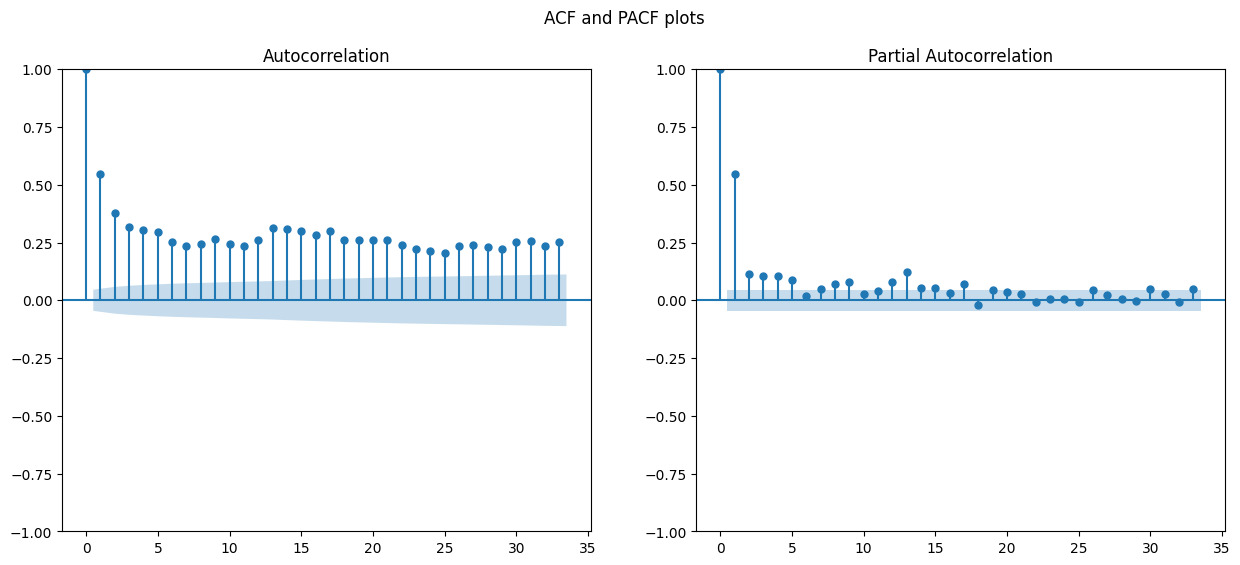

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-29042.914, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-28525.296, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-28717.537, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-28869.009, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-28526.991, Time=0.30 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-29044.964, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-29045.648, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-29046.564, Time=0.63 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-29044.269, Time=2.01 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-29040.770, Time=1.03 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-29016.147, Time=0.64 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-29028.150, Time=0.58 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=-29024.387, Time=0.70 sec
 ARIMA(2,1,3)(1,0,0)[12] intercept

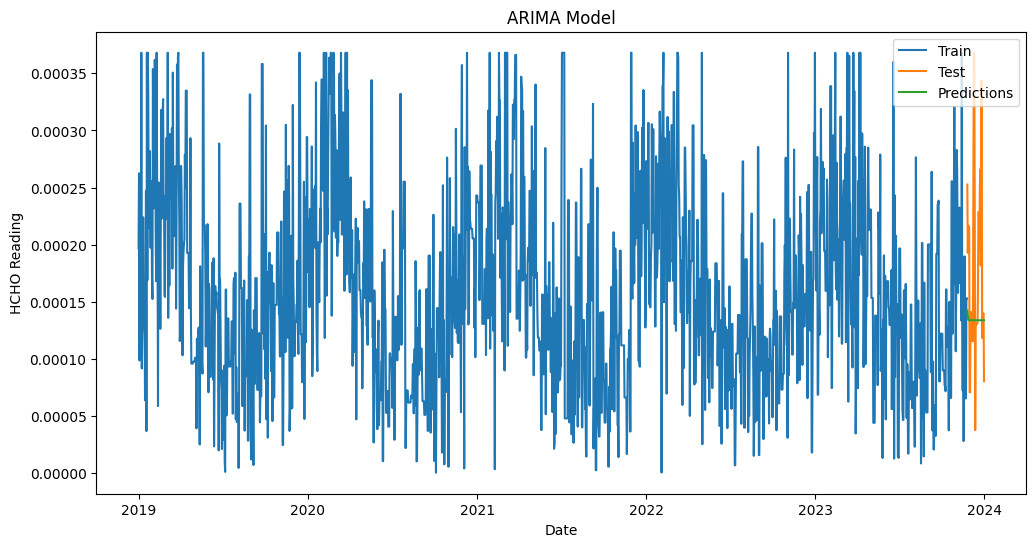

Evaluation Metrics
RMSE:  9.482765765625094e-05
MAE:  6.722223158836047e-05
MAPE:  0.3727756810571296
R2:  -0.3328317843721267
Training SARIMA model
                                      SARIMAX Results                                      
Dep. Variable:                        hcho_reading   No. Observations:                 1789
Model:             SARIMAX(0, 1, 5)x(1, 0, [], 12)   Log Likelihood               14503.979
Date:                             Sat, 20 Apr 2024   AIC                         -28993.957
Time:                                     12:30:02   BIC                         -28955.535
Sample:                                 01-01-2019   HQIC                        -28979.769
                                      - 11-24-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

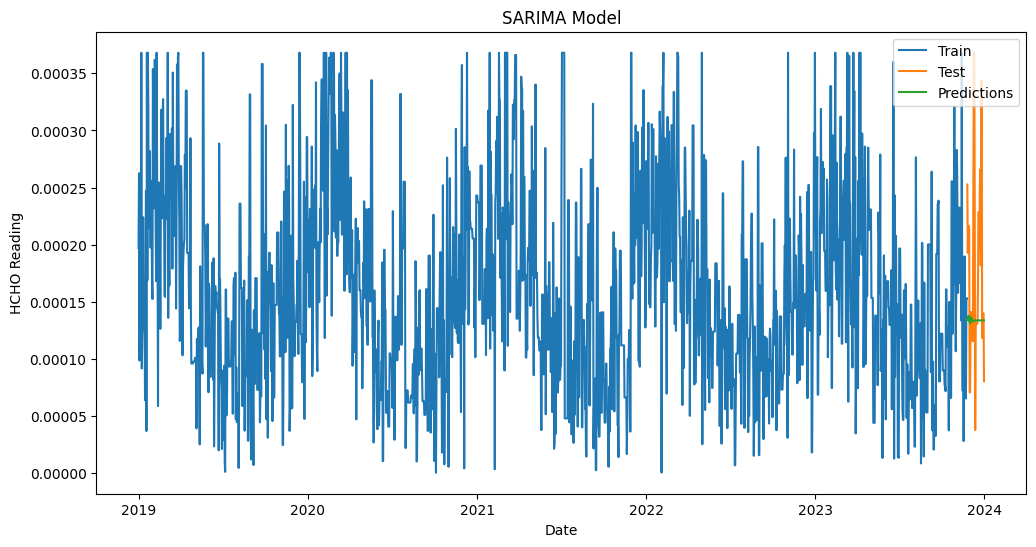

Evaluation Metrics
RMSE:  9.496200122026658e-05
MAE:  6.707406641401021e-05
MAPE:  0.3703124242597382
R2:  -0.3366109393785306


In [13]:
colombo = get_dataframe("Colombo Proper")[1]

# Plot the ACF and PACF
plot_acf_pacf(colombo, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(colombo)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")


#### 2. Deniyaya, Matara

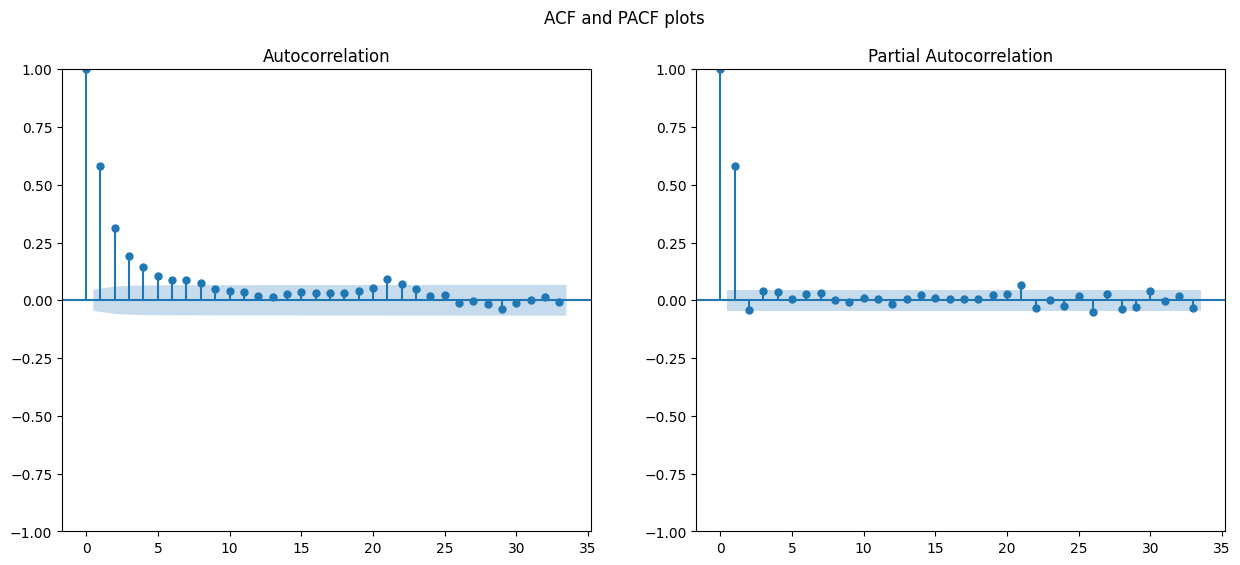

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27198.042, Time=3.00 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26639.078, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26604.338, Time=0.74 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-27122.789, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24750.504, Time=0.07 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-27247.572, Time=2.28 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-27262.519, Time=1.02 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-26593.826, Time=1.14 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-27269.186, Time=0.97 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-26614.747, Time=2.05 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-27253.071, Time=0.84 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-27224.078, Time=2.43 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-27216.791, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept

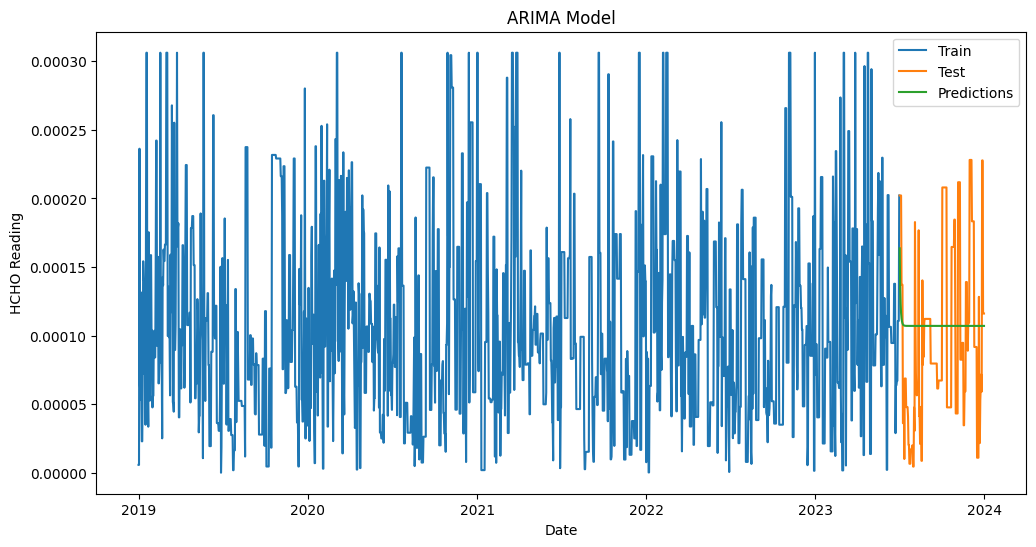

Evaluation Metrics
RMSE:  6.377963504713272e-05
MAE:  5.413809470818505e-05
MAPE:  1.627758972033837
R2:  -7.328891856661635e-05
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(1, 0, 2)   Log Likelihood               13557.808
Date:                Sat, 20 Apr 2024   AIC                         -27107.615
Time:                        07:30:55   BIC                         -27085.998
Sample:                    01-01-2019   HQIC                        -27099.599
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9672    3.4e-20   2.85e+19      0.000     

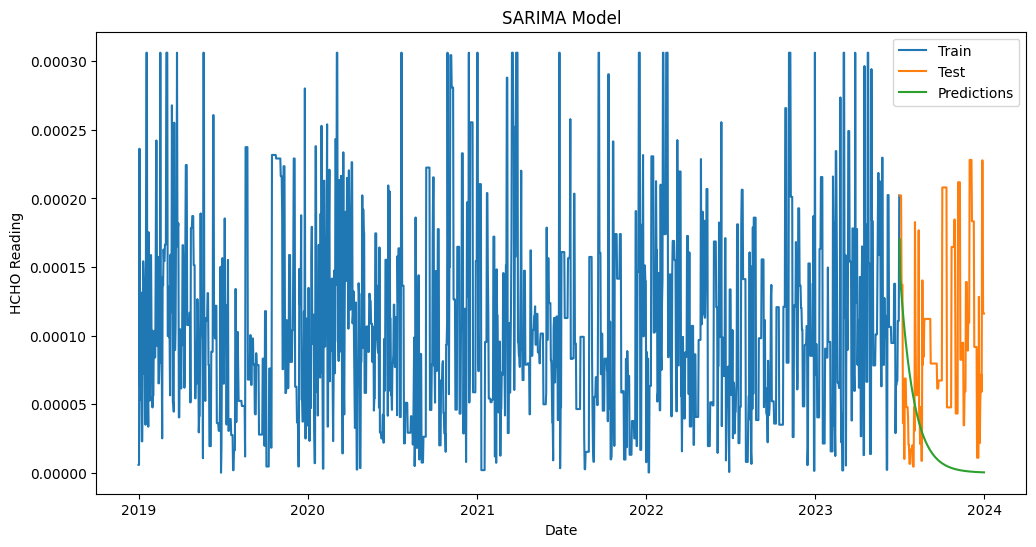

Evaluation Metrics
RMSE:  0.00010665937936816603
MAE:  8.727169447116112e-05
MAPE:  1.2383885711168987
R2:  -1.796828733005201


In [45]:
matara = get_dataframe("Deniyaya, Matara")[1]

# Plot the ACF and PACF
plot_acf_pacf(matara, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(matara)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

#### 3. Jaffna Proper

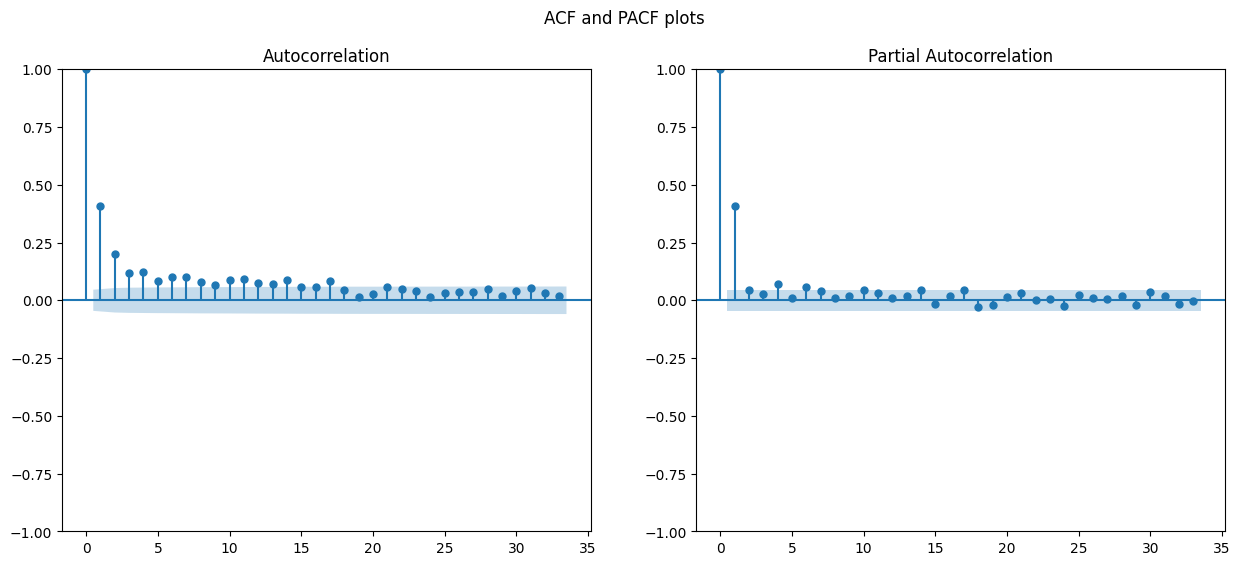

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27080.461, Time=16.93 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26999.794, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26588.240, Time=1.34 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-27225.026, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24743.427, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-27220.790, Time=0.54 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-27007.911, Time=2.91 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-27224.207, Time=4.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-26569.033, Time=1.46 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=11.44 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-27010.411, Time=0.94 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-27299.071, Time=1.66 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-27305.436, Time=0.56 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : 

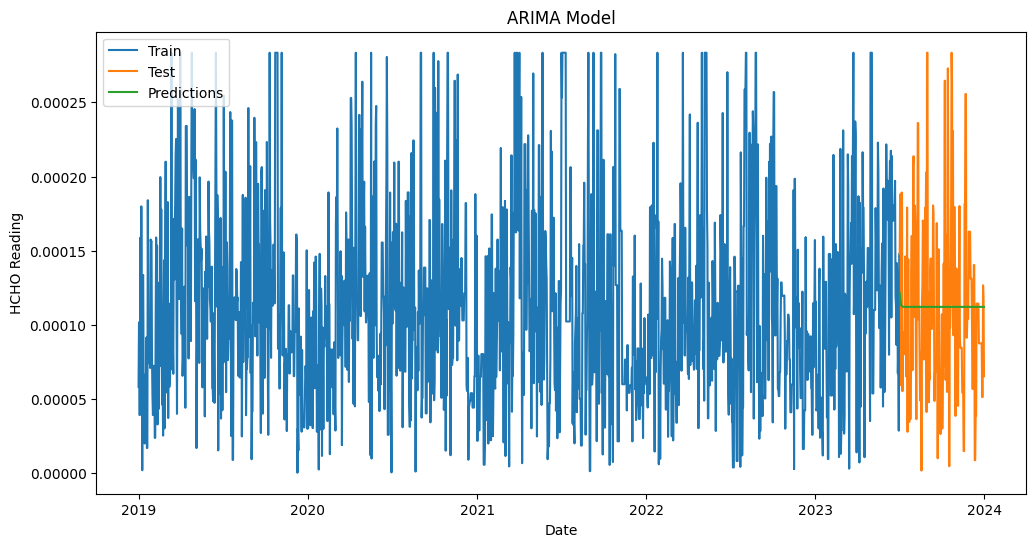

Evaluation Metrics
RMSE:  6.254944504829654e-05
MAE:  5.01169681743486e-05
MAPE:  1.258443829781541
R2:  0.0023709403364505777
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(2, 0, 0)   Log Likelihood               13498.596
Date:                Sat, 20 Apr 2024   AIC                         -26991.192
Time:                        07:32:57   BIC                         -26974.979
Sample:                    01-01-2019   HQIC                        -26985.180
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6136   8.58e-20   7.15e+18      0.000       

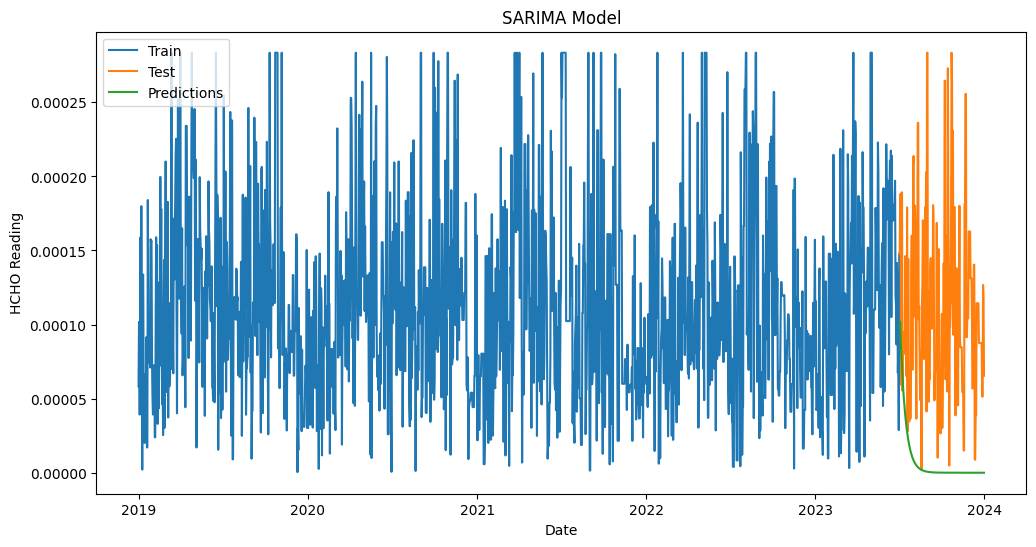

Evaluation Metrics
RMSE:  0.0001226011868165474
MAE:  0.00010477371831057519
MAPE:  0.921578030484951
R2:  -2.8327590512030794


In [46]:
jaffna = get_dataframe("Jaffna Proper")[1]

# Plot the ACF and PACF
plot_acf_pacf(jaffna, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(jaffna)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

##### 4. Kandy Proper

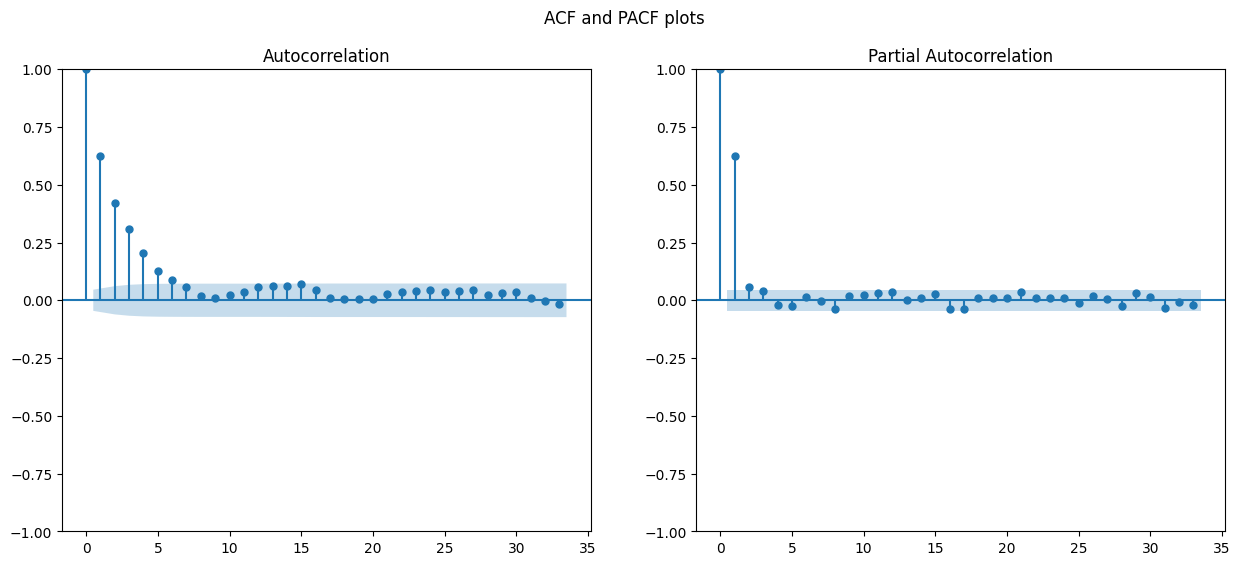

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27327.270, Time=2.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26623.797, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26704.944, Time=1.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-27118.362, Time=1.46 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24534.408, Time=0.08 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-27381.111, Time=0.87 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-27393.594, Time=0.36 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-26707.781, Time=2.08 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-27397.198, Time=0.37 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-26702.982, Time=1.04 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-27386.119, Time=2.09 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-27354.565, Time=2.60 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-27253.635, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept

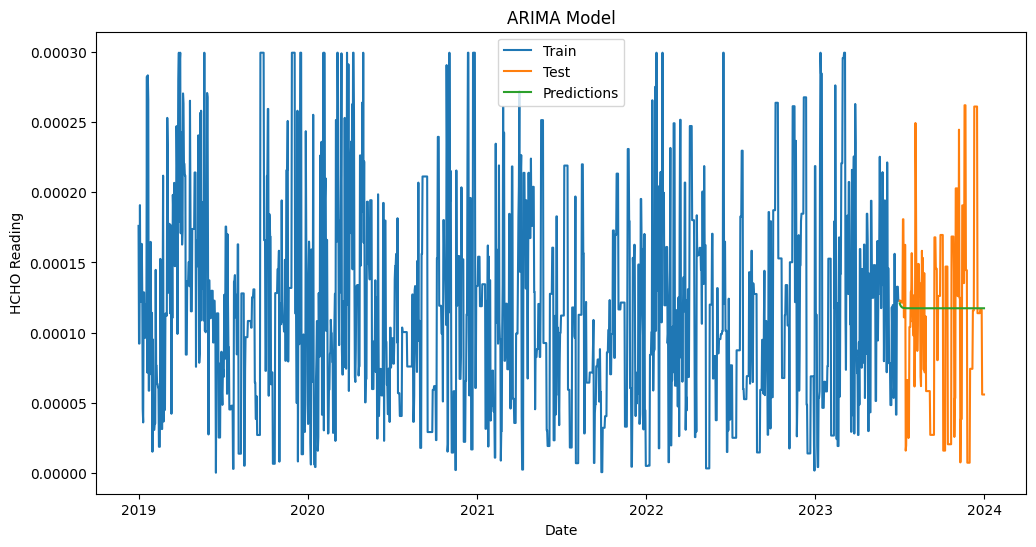

Evaluation Metrics
RMSE:  6.679072569458509e-05
MAE:  5.3113319627074324e-05
MAPE:  1.562812908646641
R2:  -0.014708826329905778
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(3, 0, 0)   Log Likelihood               13621.293
Date:                Sat, 20 Apr 2024   AIC                         -27234.585
Time:                        07:34:34   BIC                         -27212.968
Sample:                    01-01-2019   HQIC                        -27226.569
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6789      2e-19   3.39e+18      0.000     

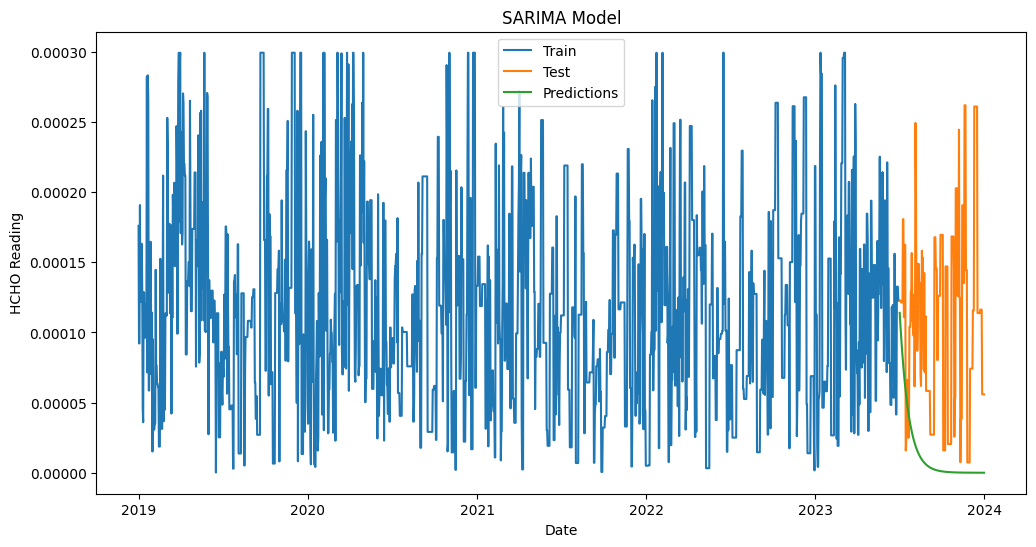

Evaluation Metrics
RMSE:  0.00011973186544798642
MAE:  9.824209383811062e-05
MAPE:  0.8997069792454168
R2:  -2.2608334064638007


In [47]:
kandy = get_dataframe("Kandy Proper")[1]

# Plot the ACF and PACF
plot_acf_pacf(kandy, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(kandy)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

##### 5. Bibile, Monaragala

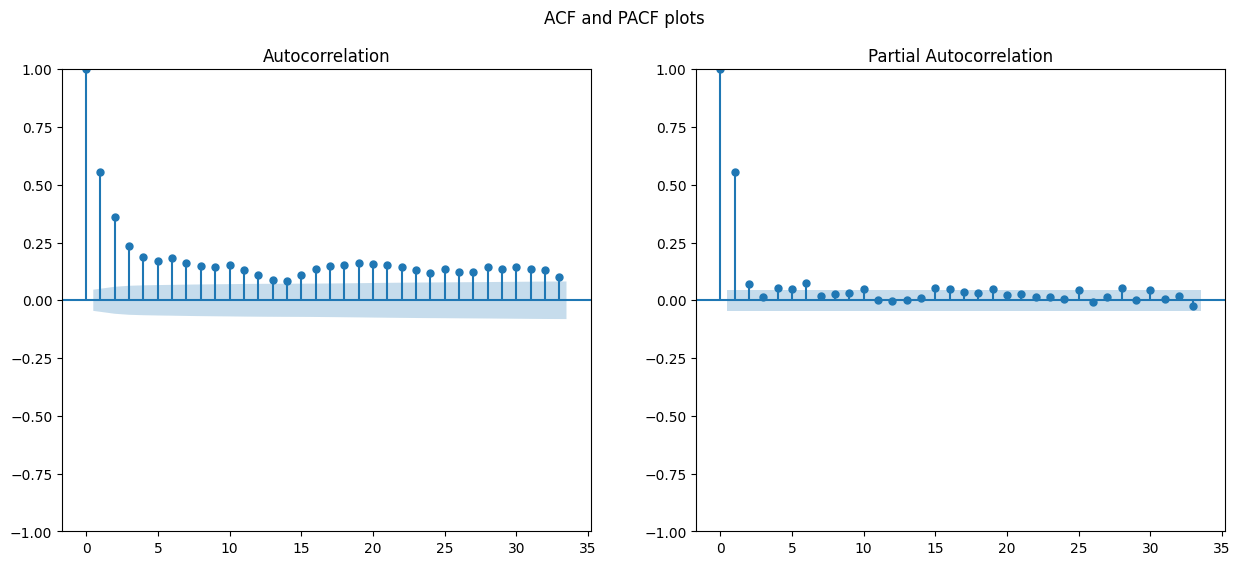

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27068.800, Time=2.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26536.483, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26357.024, Time=1.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-26921.958, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24275.744, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-27121.305, Time=2.25 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-27126.397, Time=0.83 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-26352.666, Time=2.24 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-27129.113, Time=0.73 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-26355.163, Time=1.83 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-27124.027, Time=1.90 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-27066.392, Time=2.26 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-27027.206, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept

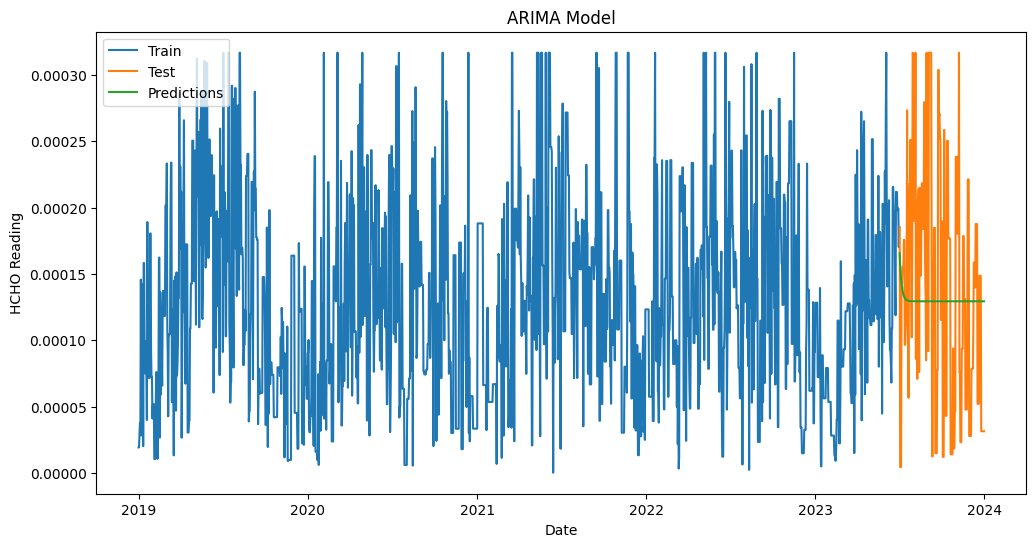

Evaluation Metrics
RMSE:  9.025633141678097e-05
MAE:  7.615495881229202e-05
MAPE:  1.9395061087058554
R2:  -0.022098363891597028
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(5, 0, 0)   Log Likelihood               13513.294
Date:                Sat, 20 Apr 2024   AIC                         -27014.589
Time:                        07:44:59   BIC                         -26982.163
Sample:                    01-01-2019   HQIC                        -27002.564
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5751   1.27e-19   4.53e+18      0.000     

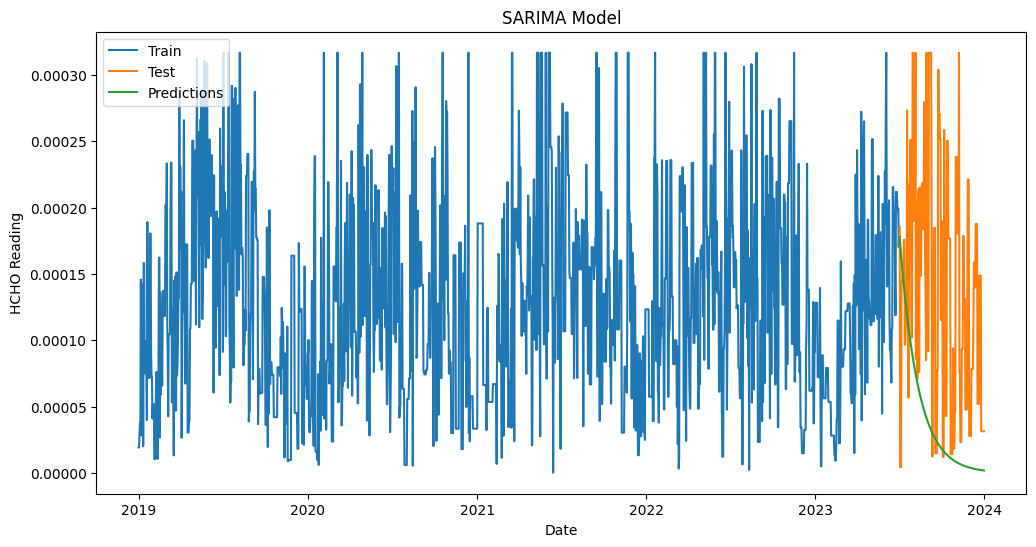

Evaluation Metrics
RMSE:  0.00013792513089994616
MAE:  0.00010941051727009014
MAPE:  1.3266297406591272
R2:  -1.3868446228179896


In [48]:
bibile = get_dataframe("Bibile, Monaragala")[1]

# Plot the ACF and PACF
plot_acf_pacf(bibile, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(bibile)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

##### 6. Kurunegala Proper

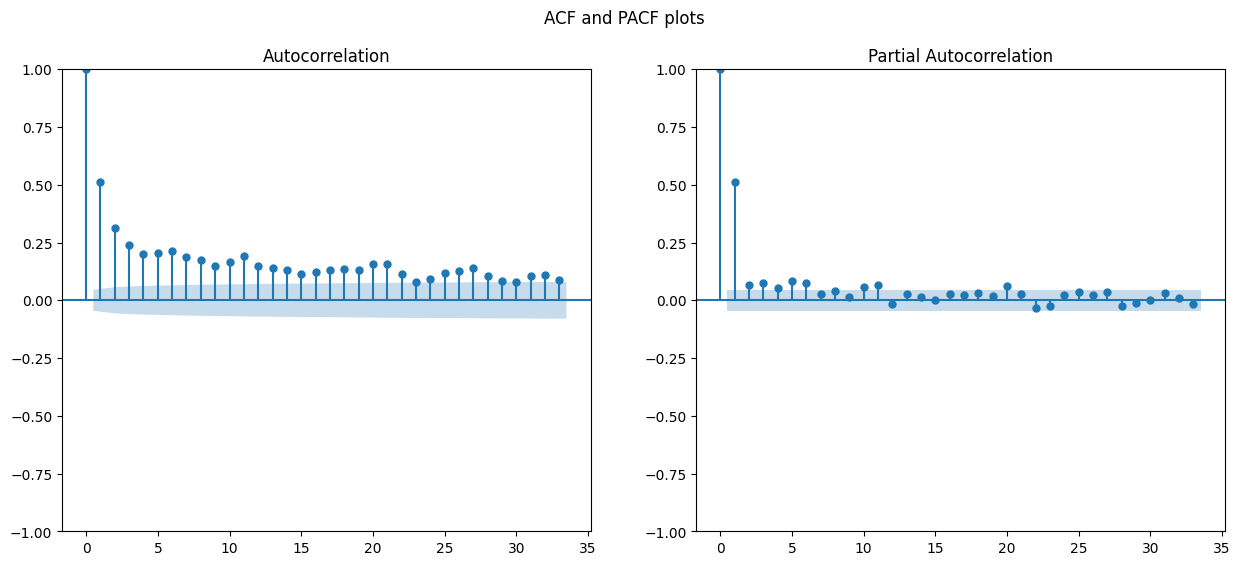

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27063.577, Time=11.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26634.646, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-26316.670, Time=1.48 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-26978.721, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24173.008, Time=0.08 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-27119.165, Time=1.99 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-27134.320, Time=0.92 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-26343.234, Time=2.31 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-27141.503, Time=0.69 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-26345.271, Time=2.15 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-27127.112, Time=1.70 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-27050.533, Time=3.85 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-27040.796, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[12] intercep

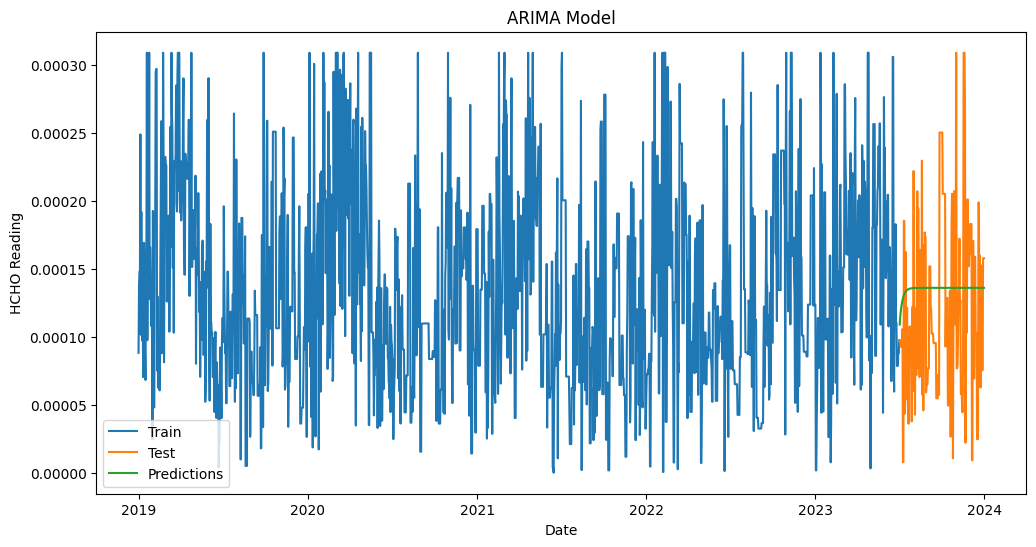

Evaluation Metrics
RMSE:  6.671743392256603e-05
MAE:  5.5490151897952975e-05
MAPE:  1.0316882452330558
R2:  -0.03455087920237232
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(1, 0, 2)   Log Likelihood               13529.412
Date:                Sat, 20 Apr 2024   AIC                         -27050.824
Time:                        07:50:42   BIC                         -27029.207
Sample:                    01-01-2019   HQIC                        -27042.808
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917   1.57e-20   6.32e+19      0.000     

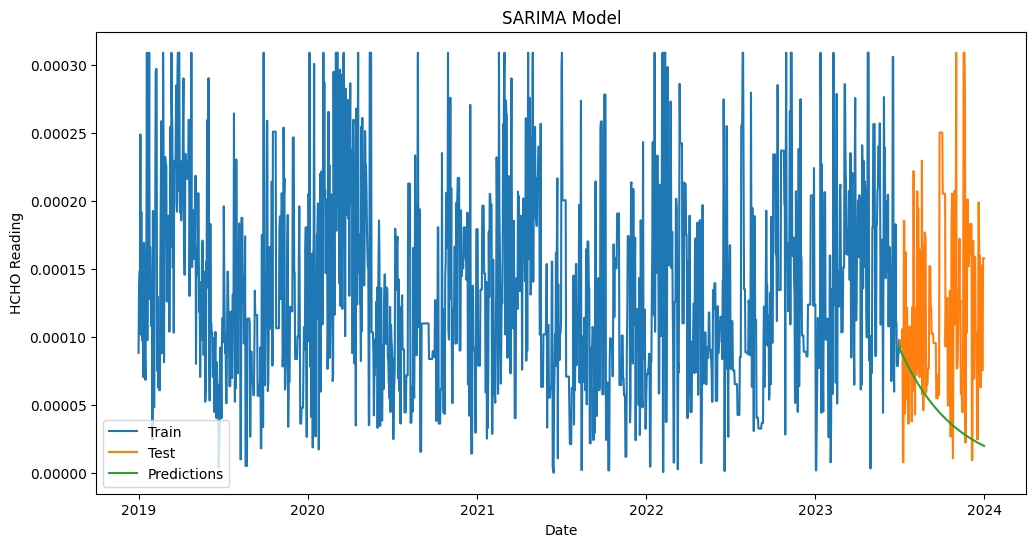

Evaluation Metrics
RMSE:  0.00010389595617440373
MAE:  8.013177261102793e-05
MAPE:  0.6839780922656575
R2:  -1.508825610878898


In [49]:
kurunegala = get_dataframe("Kurunegala Proper")[1]

# Plot the ACF and PACF
plot_acf_pacf(kurunegala, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(kurunegala)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

##### 7. Nuwara Eliya Proper

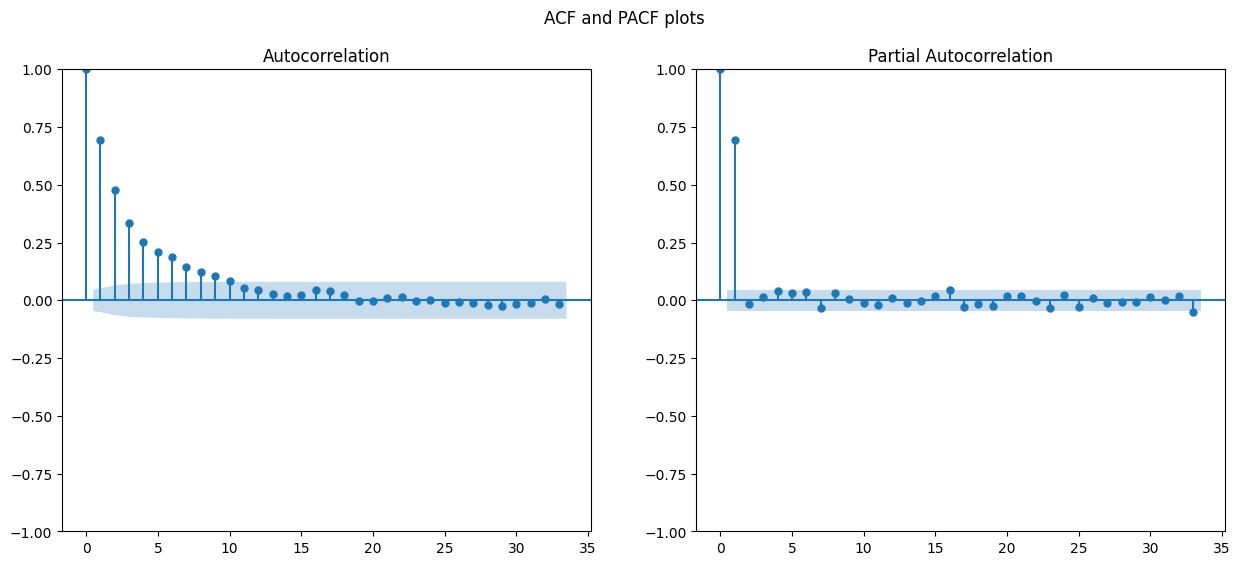

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-27718.415, Time=2.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-26848.043, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-27223.632, Time=1.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-27501.222, Time=1.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-24917.312, Time=0.17 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-27817.675, Time=2.23 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-27839.269, Time=0.79 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-27221.289, Time=1.94 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-27858.005, Time=0.98 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-27223.464, Time=1.96 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-27832.526, Time=0.80 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-27767.818, Time=2.45 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-27709.887, Time=0.66 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept

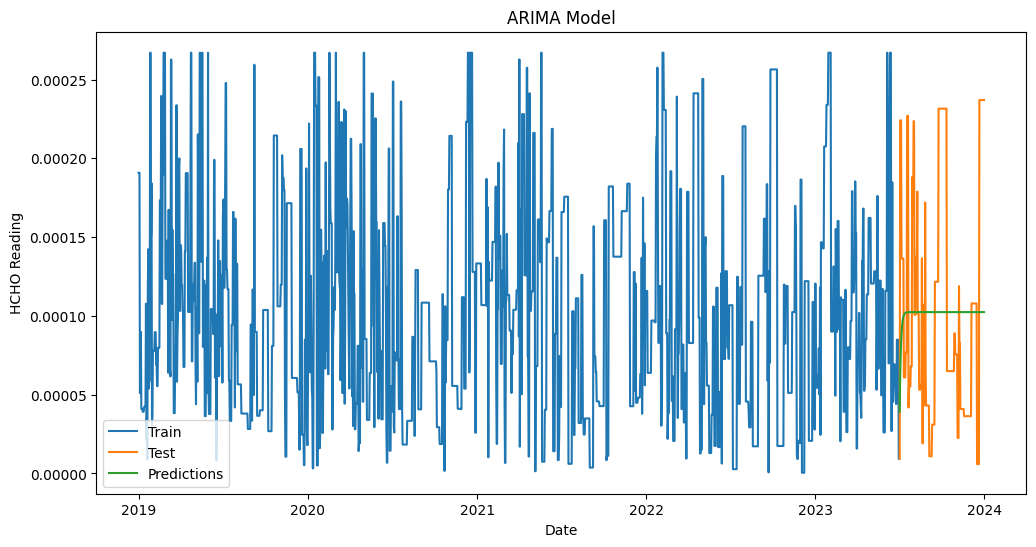

Evaluation Metrics
RMSE:  7.5567031304134e-05
MAE:  6.269243019544227e-05
MAPE:  1.5084708626002197
R2:  -0.01958355552298241
Training SARIMA model
                               SARIMAX Results                                
Dep. Variable:           hcho_reading   No. Observations:                 1643
Model:               SARIMAX(1, 0, 0)   Log Likelihood               13831.203
Date:                Sat, 20 Apr 2024   AIC                         -27658.407
Time:                        07:51:56   BIC                         -27647.598
Sample:                    01-01-2019   HQIC                        -27654.398
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9004   1.89e-19   4.77e+18      0.000       0

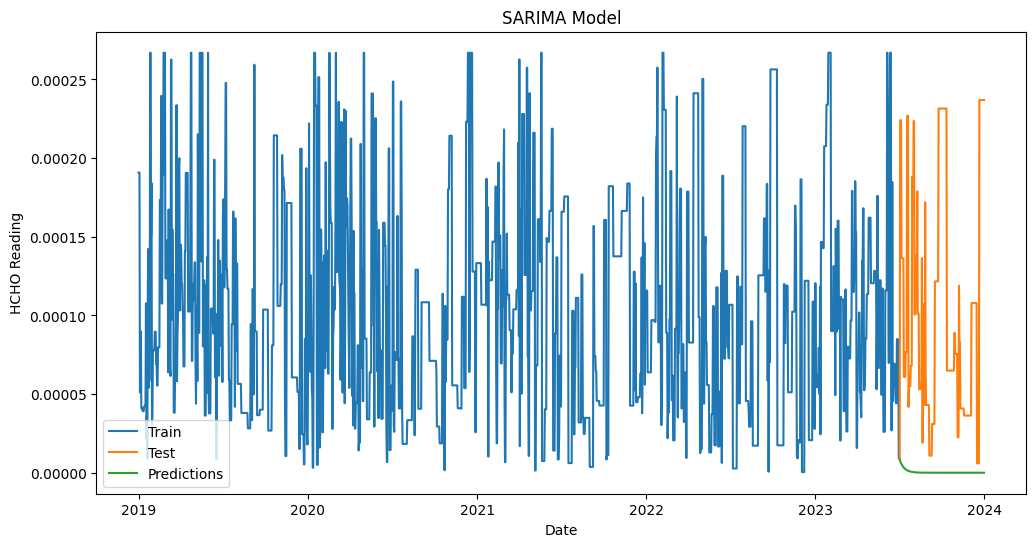

Evaluation Metrics
RMSE:  0.00012631447075537257
MAE:  0.00010186934633876569
MAPE:  0.9912637631277623
R2:  -1.8488154352797914


In [51]:
nuwara_eliya = get_dataframe("Nuwara Eliya Proper")[1]

# Plot the ACF and PACF
plot_acf_pacf(nuwara_eliya, "hcho_reading")

# Split the data into training and testing sets
train, test = split_data(nuwara_eliya)

# Training auto_arima model
print("Training auto_arima model")
auto_arima_model = auto_arima(train["hcho_reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Train the ARIMA model
print("Training ARIMA model")
arima_model = train_arima(train,"hcho_reading", order)

# Evaluate the model
evaluate_model(arima_model,"hcho_reading",train, test, "ARIMA")

# Train the SARIMA model
print("Training SARIMA model")
sarima_model = train_sarima(train, "hcho_reading", order, seasonal_order)

# Evaluate the model
evaluate_model(sarima_model, "hcho_reading", train, test, "SARIMA")

Conclusion

Training ARIMA and Sarima model using auto_arima model is not good. The accuracy of the predictions are very low

# Manually adding SARIMA parameters

In [21]:
def manual_SARIMA(city_data, order, seasonal_order, city_name):
    train_data, test_data = split_data(city_data)

    model = SARIMAX(train_data['hcho_reading'], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # print the summary of the model
    print(results.summary())

    # Generate future forecast
    forecast_steps = len(test_data)  # Forecast for the entire test period
    forecast = results.get_forecast(steps=forecast_steps)

    # Extract forecasted values and confidence intervals
    forecast_values = forecast.predicted_mean.to_frame()
    confidence_intervals = forecast.conf_int()

    # plot the train, test, confidence intervals and forecast
    plt.figure(figsize=(10, 6))
    # plt.plot(train_data.index, train_data['hcho_reading'], label='Training')
    plt.plot(test_data.index, test_data['hcho_reading'], label='Test')
    plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
    plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='green', alpha=0.3)
    plt.title(f'{city_name}: SARIMAX Model Fit and Forecast')
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Calculate the RMSE, MAE and MAPE, R2
    rmse = np.sqrt(mean_squared_error(test_data['hcho_reading'], forecast_values['predicted_mean']))
    mae = mean_absolute_error(test_data['hcho_reading'], forecast_values['predicted_mean'])

    # print the results
    print("Evaluation Metrics")
    print("RMSE: ", rmse)
    print("MAE: ", mae)

In [20]:
mean_absolute_percentage_error?

Signature:
mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note here that the output is not a percentage in the range [0, 100]
and a value of 100 does not mean 100% but 1e2. Furthermore, the output
can be arbitrarily high when `y_true` is small (which is specific to the
metric) or when `abs(y_true - y_pred)` is large (which is common for most
regression metrics). Read more in the
:ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines aggregat

In [62]:
def forecast_for_month(city_data, order, seasonal_order, city_name, forecast_steps=30):

    model = SARIMAX(city_data['hcho_reading'], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Generate future forecast
    forecast = results.get_forecast(steps=forecast_steps)

    # Extract forecasted values
    forecast_values = forecast.predicted_mean.to_frame().rename(columns={'predicted_mean': 'hcho_reading'})

    # plot the train, test, confidence intervals and forecast
    plt.figure(figsize=(10, 6))
    city_data = city_data.loc["2023-01-01":]
    plt.plot(city_data.index, city_data['hcho_reading'], label='Actual')
    plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
    plt.title(f'{city_name}: SARIMAX Model Fit and Forecast')
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    return forecast_values
    

##### 1. Colombo

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14186.033
Date:                            Sat, 20 Apr 2024   AIC                         -28362.066
Time:                                    13:34:08   BIC                         -28334.655
Sample:                                01-01-2019   HQIC                        -28351.940
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4017   7.56e-19   5.31e+17      0.000       0.402       0.402
ma.L1         -0.8507   1.18e-18  -

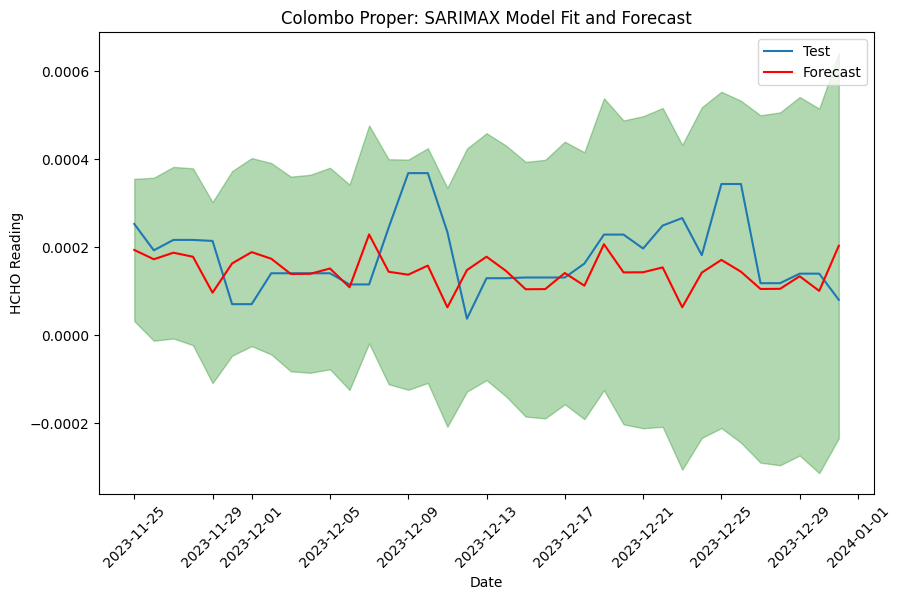

Evaluation Metrics
RMSE:  9.87332901979574e-05
MAE:  7.312202989814098e-05


In [63]:
# Get colombo dataset
colombo = get_dataframe("Colombo Proper")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(colombo, (1, 1, 1), (1, 1, 1, 12), "Colombo Proper")

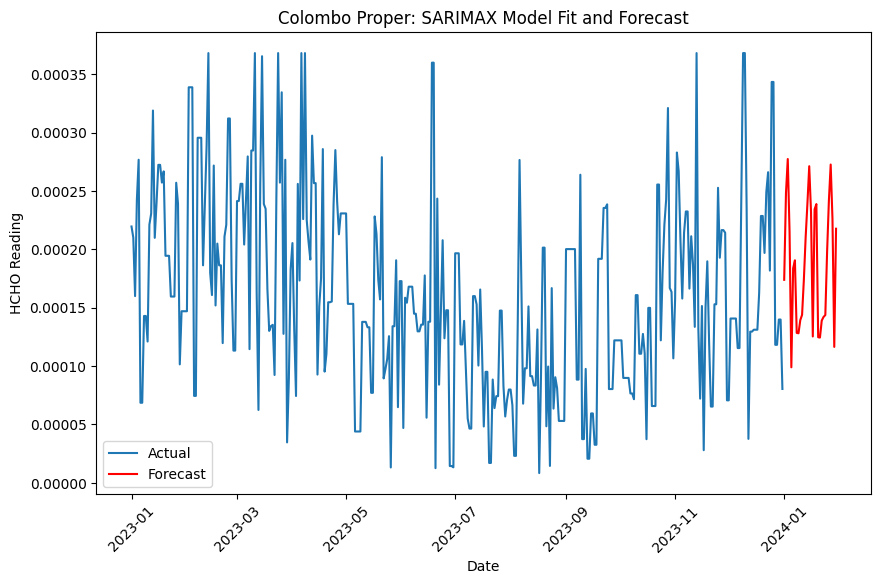

In [64]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
colombo_forecast = forecast_for_month(colombo, (1, 1, 1), (1, 1, 1, 12), "Colombo Proper")

# concat the forecasted values to the original dataset
colombo_forecast = pd.concat([colombo, colombo_forecast])

#### 2. Bibile, Monaragala

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               14439.092
Date:                            Sat, 20 Apr 2024   AIC                         -28868.184
Time:                                    13:35:52   BIC                         -28840.771
Sample:                                01-01-2019   HQIC                        -28858.058
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5364    4.1e-19   1.31e+18      0.000       0.536       0.536
ma.L1         -0.0543    3.1e-19  -

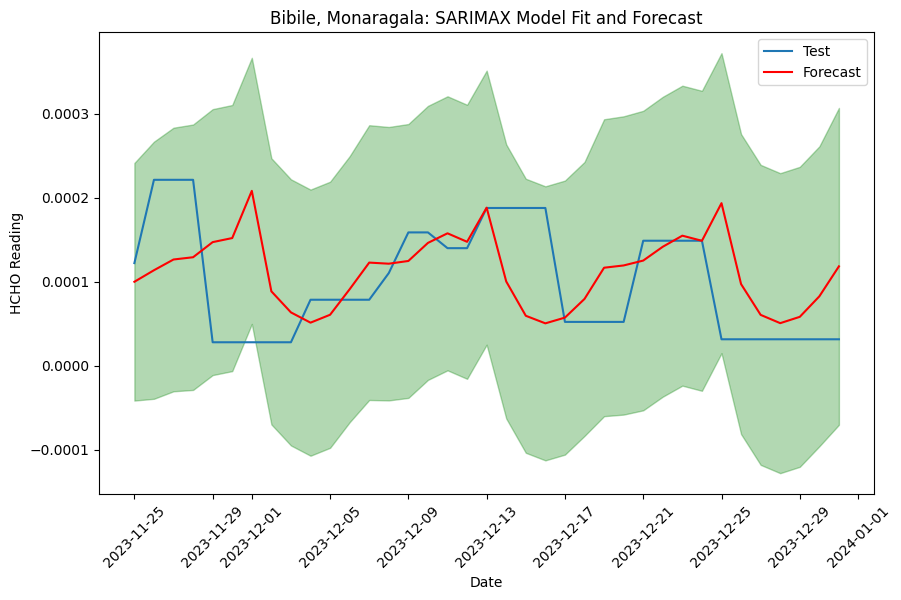

Evaluation Metrics
RMSE:  7.302776764132794e-05
MAE:  5.4504441385340514e-05


In [65]:
# Get monaragala dataset
monaragala = get_dataframe("Bibile, Monaragala")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(monaragala, (1, 0, 1), (1, 1, 1, 12), "Bibile, Monaragala")

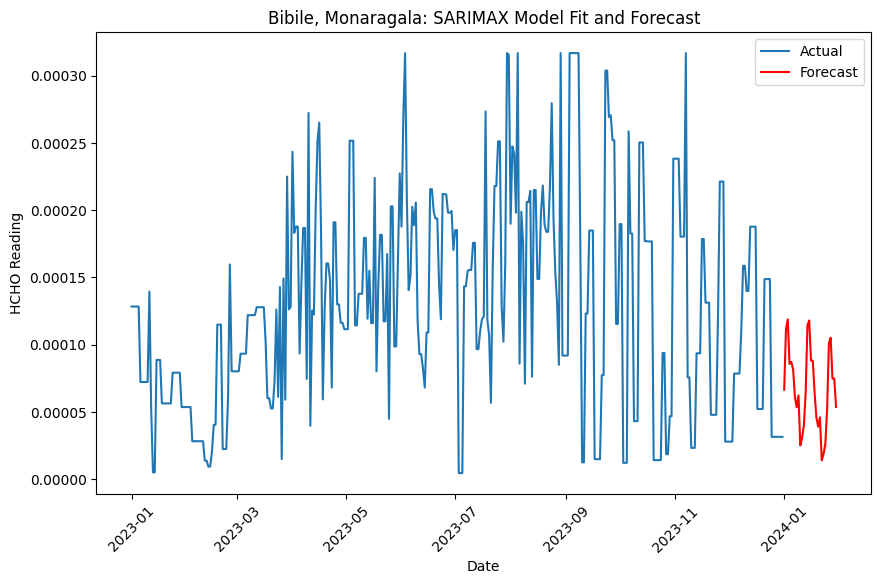

In [66]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
monaragala_forecast = forecast_for_month(monaragala, (2, 1, 1), (1, 1, 1, 12), "Bibile, Monaragala")

# Concat two dataframes to one
monaragala_forecast = pd.concat([monaragala, monaragala_forecast])

#### 3. Deniyaya, Matara

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14515.164
Date:                            Sat, 20 Apr 2024   AIC                         -29020.328
Time:                                    13:36:27   BIC                         -28992.918
Sample:                                01-01-2019   HQIC                        -29010.203
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7554   4.46e-19   1.69e+18      0.000       0.755       0.755
ma.L1         -0.9984   5.68e-19  -

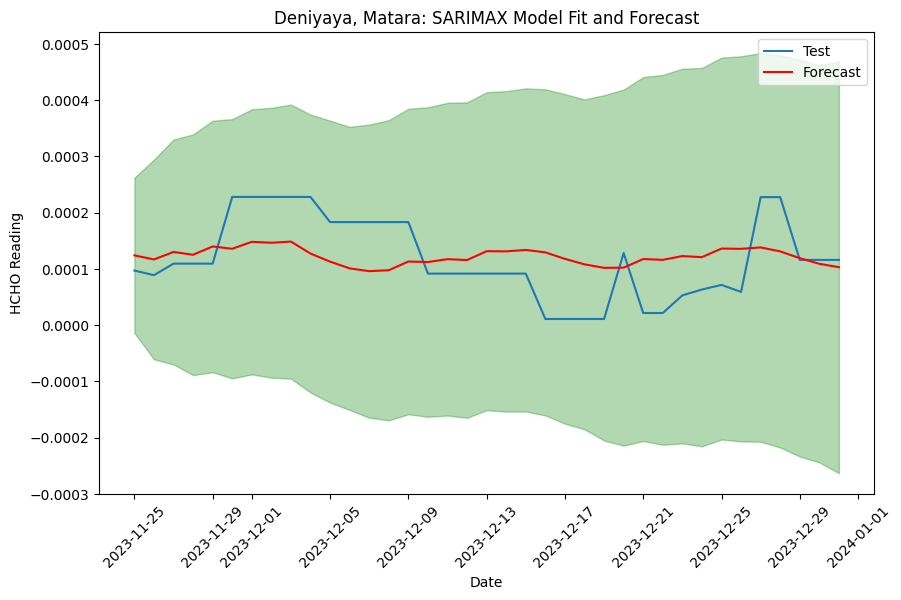

Evaluation Metrics
RMSE:  6.915847956079905e-05
MAE:  6.081698605437488e-05


In [67]:
# Get matara dataset
matara = get_dataframe("Deniyaya, Matara")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(matara, (1, 1, 1), (1, 1, 1, 12), "Deniyaya, Matara")

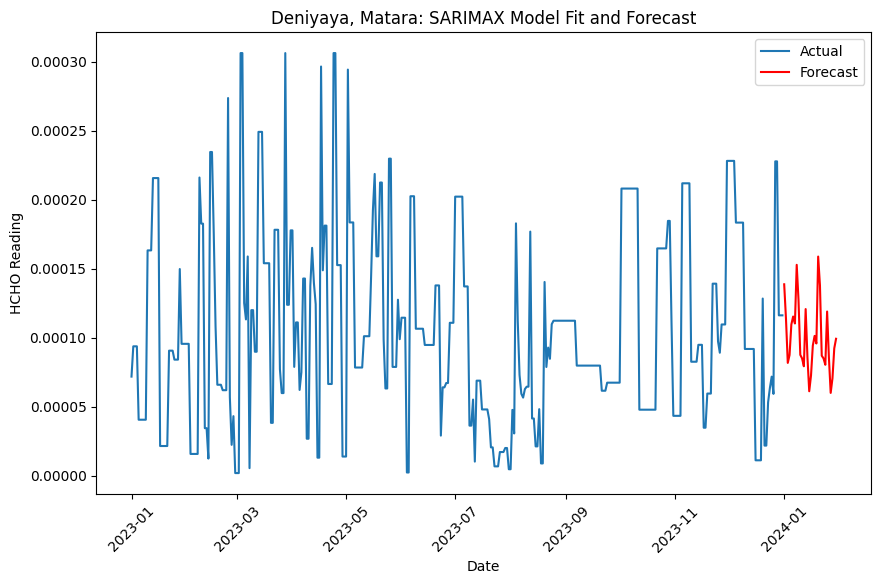

In [68]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
matara_forecast = forecast_for_month(matara, (1, 1, 1), (1, 1, 1, 12), "Deniyaya, Matara")

# Concat two dataframes to one
matara_forecast = pd.concat([matara, matara_forecast])

#### 4. Jaffna

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14449.818
Date:                            Sat, 20 Apr 2024   AIC                         -28889.636
Time:                                    13:37:05   BIC                         -28862.225
Sample:                                01-01-2019   HQIC                        -28879.511
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3881   3.96e-19    9.8e+17      0.000       0.388       0.388
ma.L1         -0.8552   6.98e-19  -

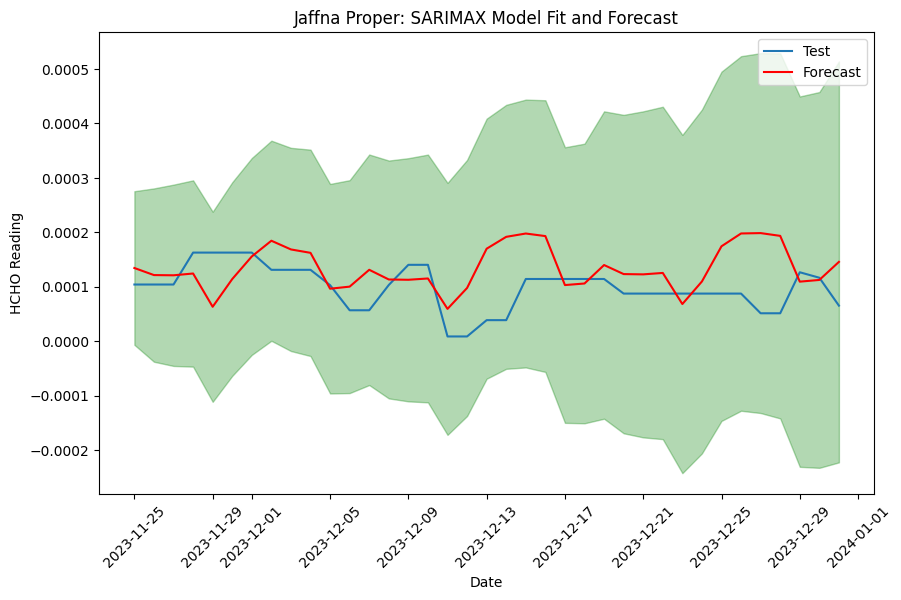

Evaluation Metrics
RMSE:  6.73533098170622e-05
MAE:  5.2358943471624356e-05


In [69]:
# Get jaffna dataset
jaffna = get_dataframe("Jaffna Proper")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(jaffna, (1, 1, 1), (1, 1, 1, 12), "Jaffna Proper")

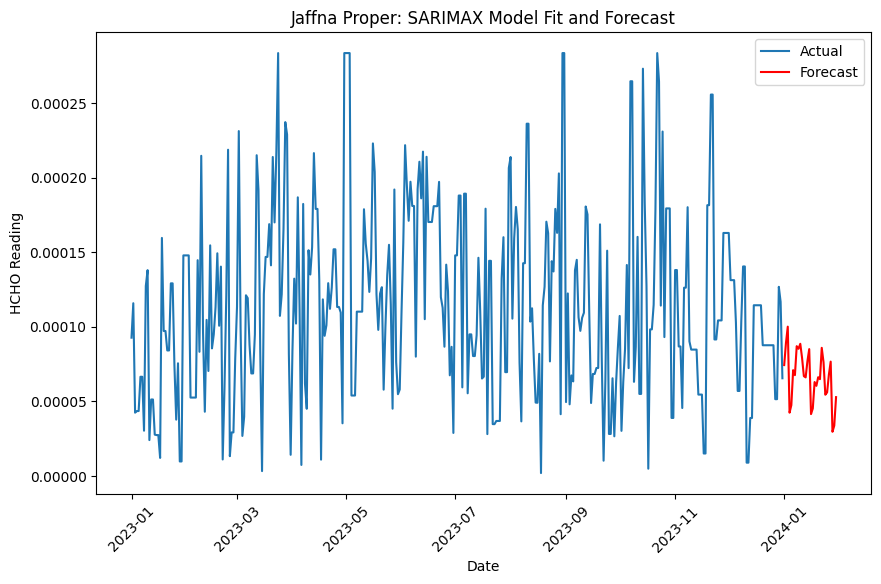

In [70]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
jaffna_forecast = forecast_for_month(jaffna, (1, 1, 1), (1, 1, 1, 12), "Jaffna Proper")

# Concat two dataframes to one
jaffna_forecast = pd.concat([jaffna, jaffna_forecast])

#### 5. Kandy

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14579.663
Date:                            Sat, 20 Apr 2024   AIC                         -29149.326
Time:                                    13:37:28   BIC                         -29121.916
Sample:                                01-01-2019   HQIC                        -29139.201
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4118    4.3e-19   9.59e+17      0.000       0.412       0.412
ma.L1         -0.7200   5.83e-19  -

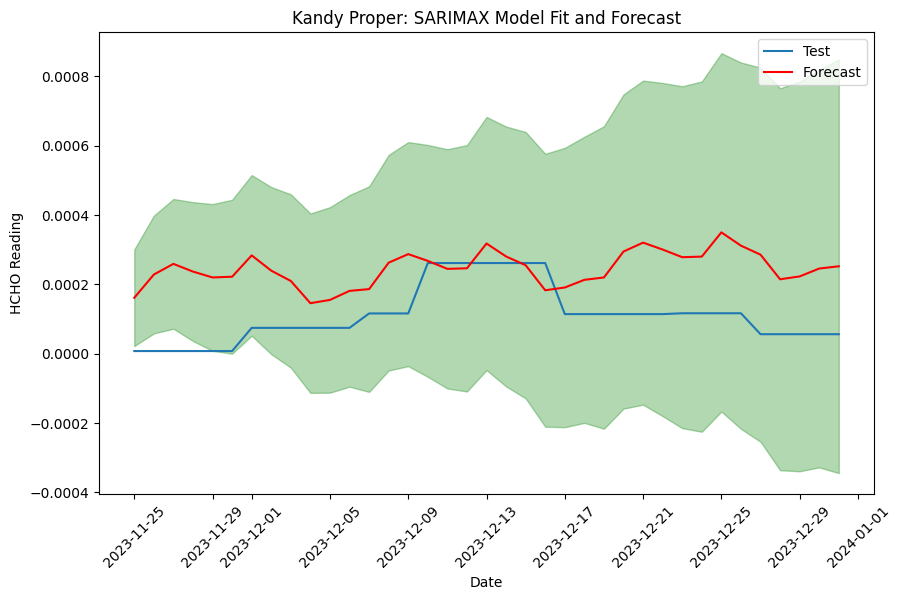

Evaluation Metrics
RMSE:  0.00015759716892251393
MAE:  0.0001400792884742009


In [71]:
# Get kandy dataset
kandy = get_dataframe("Kandy Proper")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(kandy, (1, 1, 1), (1, 1, 1, 12), "Kandy Proper")

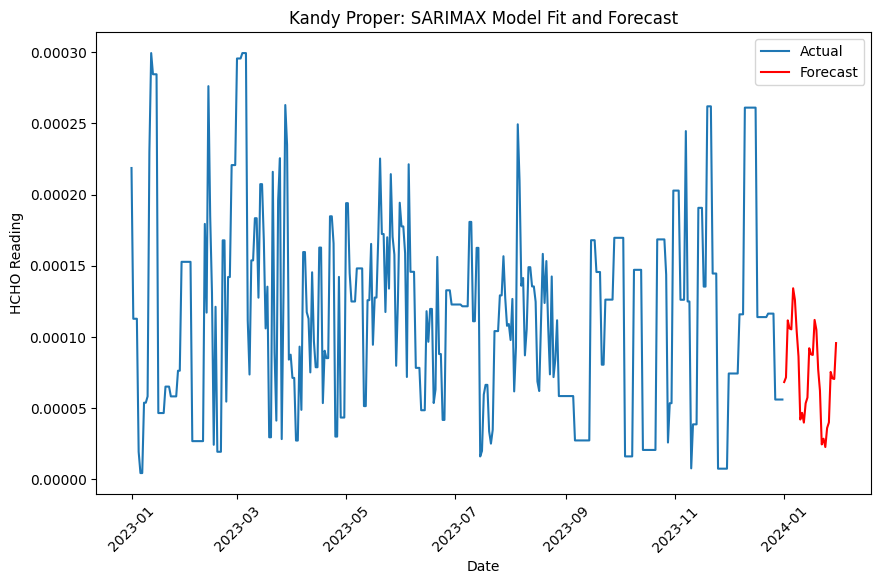

In [72]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
kandy_forecast = forecast_for_month(kandy, (1, 1, 1), (1, 1, 1, 12), "Kandy Proper")

# Concat two dataframes to one
kandy_forecast = pd.concat([kandy, kandy_forecast])

#### 6. Kurunegala

                                     SARIMAX Results                                      
Dep. Variable:                       hcho_reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14425.004
Date:                            Sat, 20 Apr 2024   AIC                         -28840.009
Time:                                    13:38:36   BIC                         -28812.598
Sample:                                01-01-2019   HQIC                        -28829.883
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3051   6.47e-19   4.72e+17      0.000       0.305       0.305
ma.L1         -0.7498   1.06e-18  -

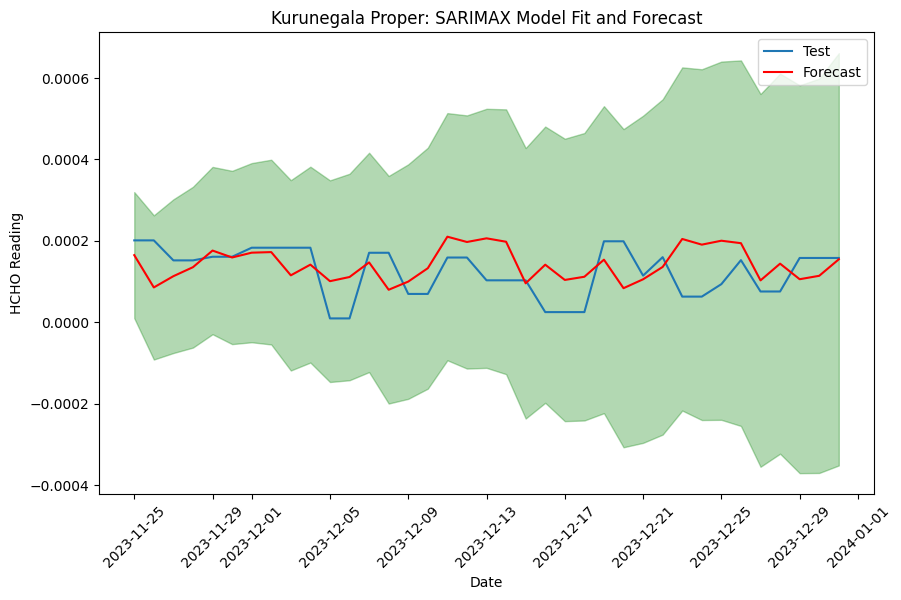

Evaluation Metrics
RMSE:  7.020680823350927e-05
MAE:  5.786854181736941e-05


In [73]:
# Get kurunegala dataset
kurunegala = get_dataframe("Kurunegala Proper")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(kurunegala, (1, 1, 1), (1, 1, 1, 12), "Kurunegala Proper")

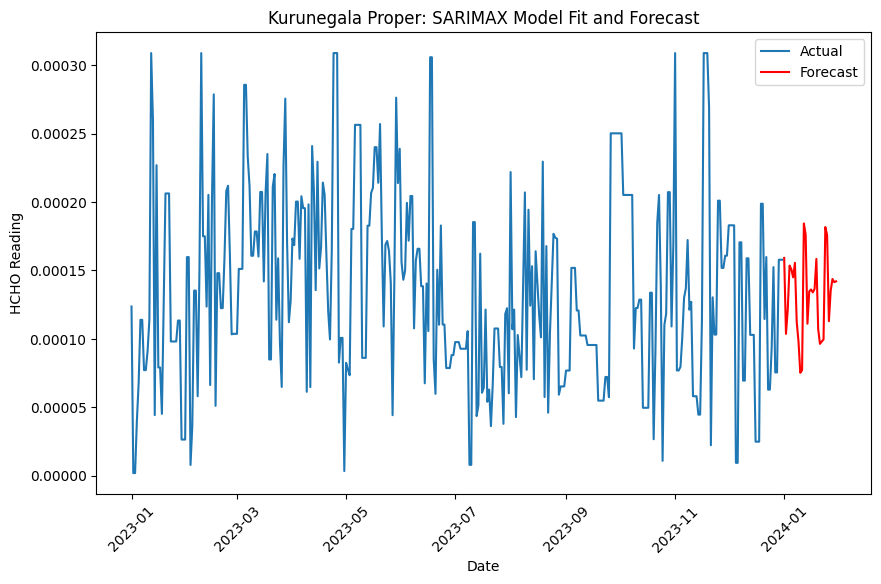

In [74]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
kurunegala_forecast = forecast_for_month(kurunegala, (1, 1, 1), (1, 1, 1, 12), "Kurunegala Proper")

# Concat two dataframes to one
kurunegala_forecast = pd.concat([kurunegala, kurunegala_forecast])

#### 7. Nuwara ELiya

                                        SARIMAX Results                                        
Dep. Variable:                            hcho_reading   No. Observations:                 1789
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               14352.729
Date:                                 Sat, 20 Apr 2024   AIC                         -28689.458
Time:                                         13:42:49   BIC                         -28645.543
Sample:                                     01-01-2019   HQIC                        -28673.242
                                          - 11-24-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       4.859e-09      0.000   2.29e-05      1.000      -0.000       0

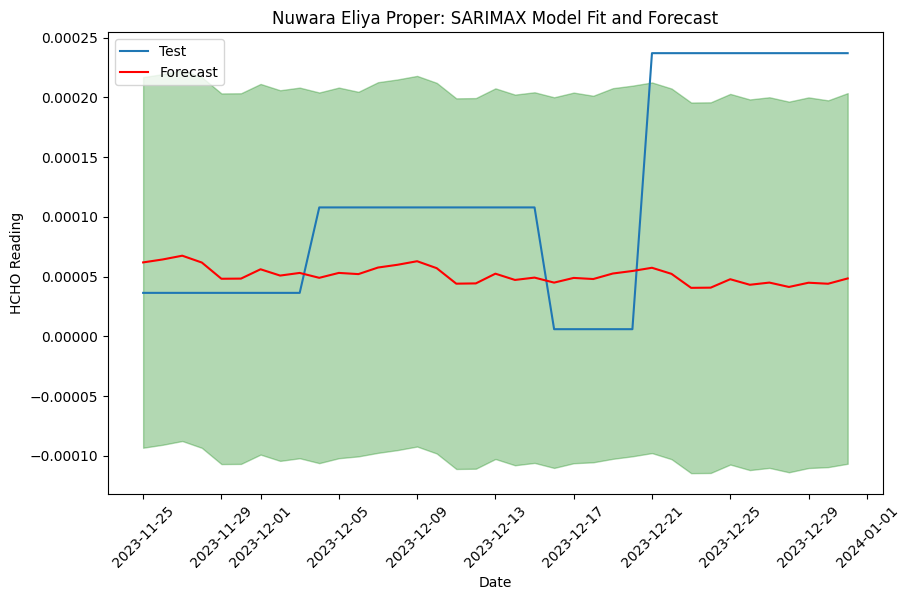

Evaluation Metrics
RMSE:  0.00011066393136666255
MAE:  8.572492734693775e-05


In [80]:
# Get nuwara eliya dataset
nuwara_eliya = get_dataframe("Nuwara Eliya Proper")[1]

# Train SARIMA and evaluate the model
manual_SARIMA(nuwara_eliya, (2, 0, 1), (2,0,2, 12), "Nuwara Eliya Proper")

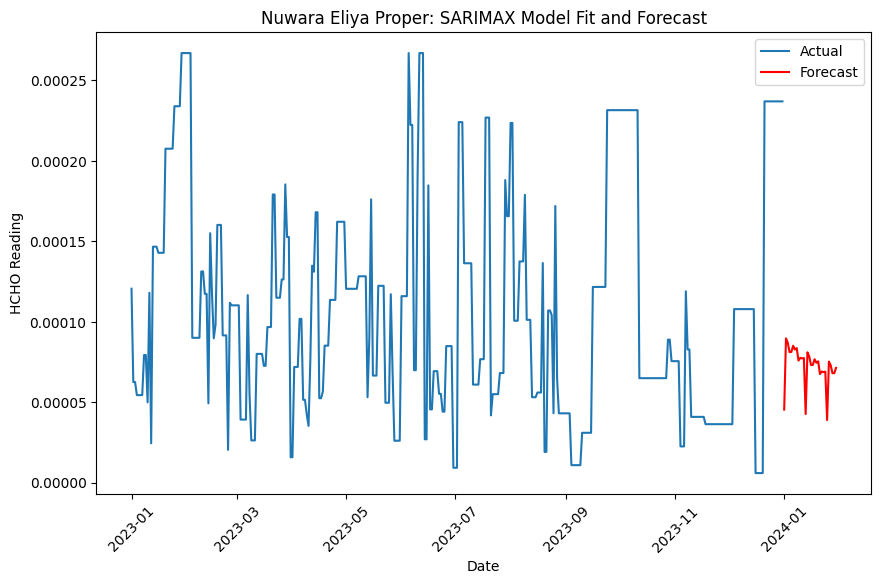

In [81]:
# Forecast for a future month (2024-01-01 to 2024-01-30)
nuwara_eliya_forecast = forecast_for_month(nuwara_eliya, (2, 0, 1), (2,0,2, 12), "Nuwara Eliya Proper")

# Concat two dataframes to one
nuwara_eliya_forecast = pd.concat([nuwara_eliya, nuwara_eliya_forecast])

In [84]:
# Add location column to every forcasted dataframes
colombo_forecast["location"] = "Colombo Proper"
monaragala_forecast["location"] = "Bibile, Monaragala"
matara_forecast["location"] = "Deniyaya, Matara"
jaffna_forecast["location"] = "Jaffna Proper"
kandy_forecast["location"] = "Kandy Proper"
kurunegala_forecast["location"] = "Kurunegala Proper"
nuwara_eliya_forecast["location"] = "Nuwara Eliya Proper"


In [85]:
# Concat all forecasted dataframes into one with filling location column to the respective city name
forecasted_data = pd.concat([colombo_forecast, monaragala_forecast, matara_forecast, jaffna_forecast, kandy_forecast, kurunegala_forecast, nuwara_eliya_forecast])


In [86]:
forecasted_data

hcho_reading             location
2019-01-01      0.000197       Colombo Proper
2019-01-02      0.000263       Colombo Proper
2019-01-03      0.000099       Colombo Proper
2019-01-04      0.000210       Colombo Proper
2019-01-05      0.000179       Colombo Proper
...                  ...                  ...
2024-01-26      0.000075  Nuwara Eliya Proper
2024-01-27      0.000073  Nuwara Eliya Proper
2024-01-28      0.000068  Nuwara Eliya Proper
2024-01-29      0.000068  Nuwara Eliya Proper
2024-01-30      0.000071  Nuwara Eliya Proper

[12992 rows x 2 columns]

In [87]:
# groupby the location and get the count for each location
forecasted_data.groupby("location").count()

hcho_reading
location                         
Bibile, Monaragala           1856
Colombo Proper               1856
Deniyaya, Matara             1856
Jaffna Proper                1856
Kandy Proper                 1856
Kurunegala Proper            1856
Nuwara Eliya Proper          1856

In [88]:
# check null values
forecasted_data.isnull().sum()

hcho_reading    0
location        0
dtype: int64

In [89]:
# Save the forecasted data to a csv file
forecasted_data.to_csv("../data/forecasted_data.csv", index=True)